In [127]:
import os
import cv2
import numpy as np
import imgaug.augmenters as iaa
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import log_loss
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from skimage.feature import local_binary_pattern
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize


In [128]:
# Augmentation and Filtering 
def preprocess_and_augment_image(img, img_size):
    # Resize image
    img_resized = cv2.resize(img, img_size)
    
    # Apply filtering 
    img_filtered = cv2.GaussianBlur(img_resized, (5, 5), 0)
    
    
    augmentations = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.Rotate((-30, 30)),  
    iaa.Multiply((0.5, 1.5)),  
    iaa.GammaContrast((0.5, 1.5)),
    iaa.AdditiveGaussianNoise(scale=(10, 40))  
   ])


    
    # Apply augmentation
    img_aug = augmentations(image=img_filtered)
    
    # Normalization
    img_normalized = img_aug / 255.0

    # Extract Features 
    color_hist = cv2.calcHist([img_resized], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256]).flatten()
    lbp = local_binary_pattern(cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY), P=8, R=1, method="uniform")
    lbp_hist = cv2.calcHist([lbp.astype(np.uint8)], [0], None, [256], [0, 256]).flatten()
    edges = cv2.Canny(img_resized, 100, 200)
    edges_hist = cv2.calcHist([edges.astype(np.uint8)], [0], None, [256], [0, 256]).flatten()
    
    # Combine features
    features = np.hstack([color_hist, lbp_hist, edges_hist])
    
    return features

In [129]:
def load_images_with_augmentation(base_path, img_size=(64, 64)):
    images = []
    labels = []
    classes = os.listdir(base_path)  
    
    for idx, folder in enumerate(classes):
        folder_path = os.path.join(base_path, folder)
        if os.path.isdir(folder_path):
            for file in os.listdir(folder_path):
                file_path = os.path.join(folder_path, file)
                img = cv2.imread(file_path)
                if img is not None:
                    img_processed = preprocess_and_augment_image(img, img_size)
                    images.append(img_processed)
                    labels.append(idx)  
    return np.array(images), np.array(labels), classes

In [130]:
base_path = r"C:\\Users\\hp\\OneDrive\\Desktop\\ML project\\food_vs"  
img_size = (128, 128)  
X, y, class_names = load_images_with_augmentation(base_path, img_size)

In [131]:
#Preparing dataset for the model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [132]:
#Scaling
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [133]:
#Dimensionality Reduction using PCA
pca = PCA(n_components=150)  
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [134]:
# Hyperparameters for tuning
# logistic_params = {
#     'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization strength (larger values reduce regularization)
#     'solver': ['liblinear', 'saga'],  # Optimizers that support both L1 and L2 regularization
#     'penalty': ['l1', 'l2'],  # Regularization penalties (L1 for sparse models, L2 for stability)
#     'class_weight': [None, 'balanced'],  # Handle class imbalance
# }

# Best parameters found
best_params = {
    'C': 10,
    'penalty': 'l2',
    'solver': 'liblinear',
    'class_weight': None
}

# Train Logistic Regression with best parameters
logistic_model = LogisticRegression(**best_params, max_iter=2000)
logistic_model.fit(X_train_pca, y_train)

LogisticRegression(C=10, max_iter=2000, solver='liblinear')

In [135]:
# Output the best hyperparameters found
#print("Best Logistic Regression Parameters:", logistic_model.best_params_)

# Evaluate the model 
y_pred_logistic = logistic_model.predict(X_test_pca)
print("Logistic Regression Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_logistic))
print(classification_report(y_test, y_pred_logistic, target_names=class_names))

Logistic Regression Results:
Accuracy: 0.499
              precision    recall  f1-score   support

      donuts       0.39      0.38      0.38       200
french_fries       0.60      0.68      0.64       200
   hamburger       0.43      0.30      0.36       200
   ice_cream       0.44      0.50      0.47       200
       pizza       0.58      0.64      0.61       200

    accuracy                           0.50      1000
   macro avg       0.49      0.50      0.49      1000
weighted avg       0.49      0.50      0.49      1000



In [136]:
# Calculate log loss
logistic_probs = logistic_model.predict_proba(X_test_pca)

loss_value = log_loss(y_test, logistic_probs)
print("Log Loss:", loss_value)

Log Loss: 1.2804048119794589


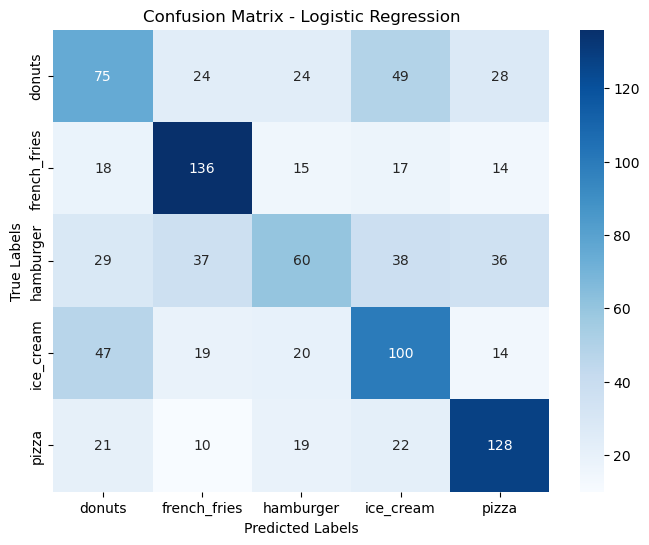

In [137]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_pred_logistic)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

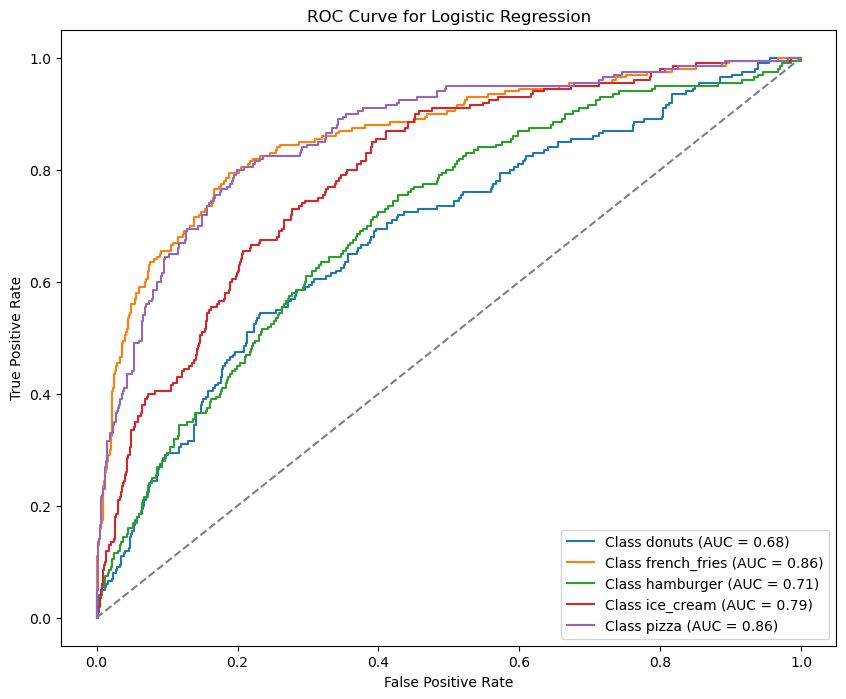

In [138]:
#ROC Curve and AUC
# Binarize the labels for multi-class ROC
y_test_bin = label_binarize(y_test, classes=range(len(class_names)))
n_classes = len(class_names)

# Calculate ROC curve and AUC for each class
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], logistic_probs[:, i])
    auc = roc_auc_score(y_test_bin[:, i], logistic_probs[:, i])
    plt.plot(fpr, tpr, label=f'Class {class_names[i]} (AUC = {auc:.2f})')

# Plot ROC curve for all classes
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line (random classifier)
plt.title('ROC Curve for Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

In [139]:
#KNN Model
# Hyperparameters for tuning
# knn_params = {
#     'n_neighbors': [3, 5, 7, 9, 11, 15],  # Number of neighbors
#     'weights': ['uniform', 'distance'],  # Weight function used in prediction
#     'metric': ['euclidean', 'manhattan', 'minkowski'],  # Distance metric
#     'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],  # Algorithm used to compute the nearest neighbors
#     'leaf_size': [20, 30, 40],  # Leaf size for tree-based algorithms
# }
knn_params = {
    'n_neighbors': 11,  # Number of neighbors
    'algorithm': 'auto',  # Algorithm used to compute the nearest neighbors
    'leaf_size': 20,  # Leaf size passed to ball_tree and kd_tree
    'metric': 'euclidean',  # Distance metric
    'weights': 'uniform',  # Weight function for prediction
}

# Initialize KNN classifier with the best hyperparameters
knn_model = KNeighborsClassifier(**knn_params)

# Fit the model to the training data
knn_model.fit(X_train_pca, y_train)

KNeighborsClassifier(leaf_size=20, metric='euclidean', n_neighbors=11)

In [140]:
# Output the best hyperparameters found
#print("Best KNN Parameters:", knn_model.best_params_)

# Evaluate the model on the test set
y_pred_knn = knn_model.predict(X_test_pca)
print("KNN Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn, target_names=class_names))

KNN Results:
Accuracy: 0.446
              precision    recall  f1-score   support

      donuts       0.31      0.26      0.28       200
french_fries       0.64      0.47      0.54       200
   hamburger       0.34      0.62      0.44       200
   ice_cream       0.49      0.41      0.44       200
       pizza       0.63      0.47      0.54       200

    accuracy                           0.45      1000
   macro avg       0.48      0.45      0.45      1000
weighted avg       0.48      0.45      0.45      1000



In [141]:
# Calculate log loss
knn_probs = knn_model.predict_proba(X_test_pca)

loss_value = log_loss(y_test, knn_probs)
print("Log Loss:", loss_value)

Log Loss: 3.3919677079234978


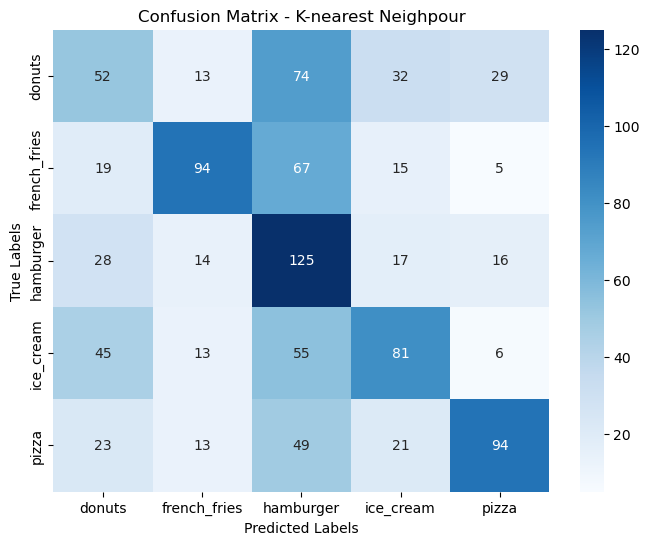

In [142]:
#Confusion Matrix

cm = confusion_matrix(y_test, y_pred_knn)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - K-nearest Neighpour')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

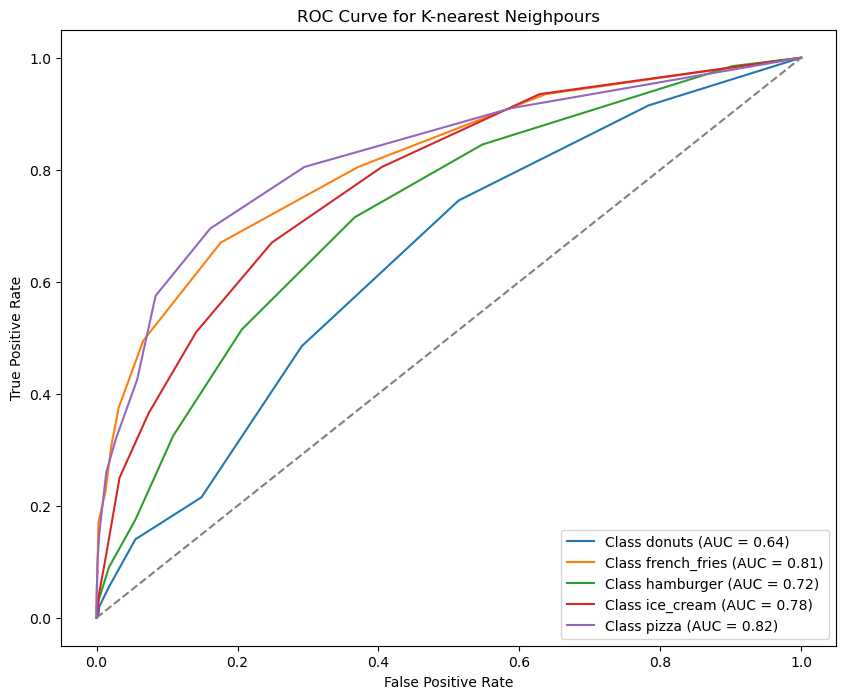

In [143]:
#ROC Curve and AUC
# Binarize the labels for multi-class ROC
y_test_bin = label_binarize(y_test, classes=range(len(class_names)))
n_classes = len(class_names)

# Calculate ROC curve and AUC for each class
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], knn_probs[:, i])
    auc = roc_auc_score(y_test_bin[:, i], knn_probs[:, i])
    plt.plot(fpr, tpr, label=f'Class {class_names[i]} (AUC = {auc:.2f})')

# Plot ROC curve for all classes
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line (random classifier)
plt.title('ROC Curve for K-nearest Neighpours')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()